In [1]:
from commonfunctions import *
import cv2
import imutils
from skimage.transform import hough_line, hough_line_peaks
from scipy.stats import mode


c:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


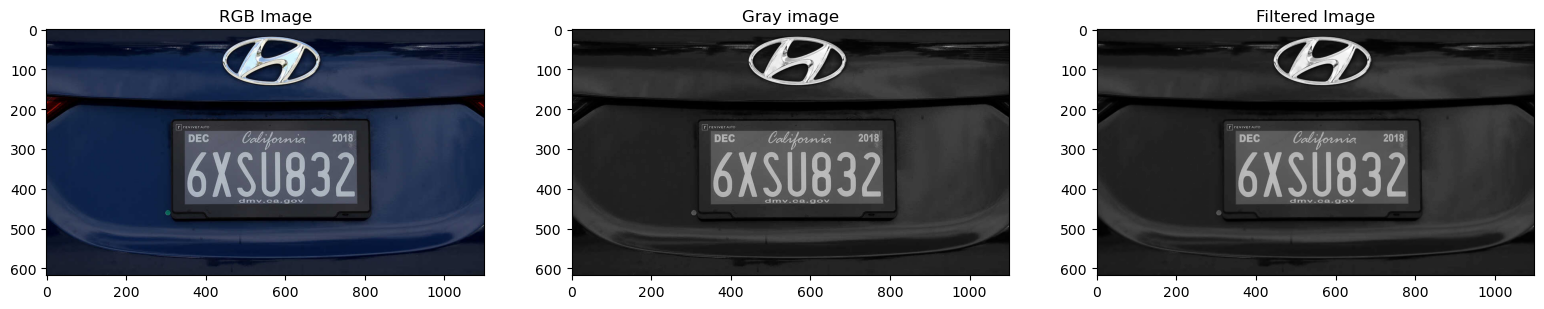

In [2]:
def preprocess_image(img):
    gray_img = rgb2gray(img)
    gray_img = (gray_img*255).astype(np.uint8)    
    filtered_img = cv2.bilateralFilter(gray_img, 5, 20, 100, borderType=cv2.BORDER_CONSTANT)
    return filtered_img



img = io.imread('imgs/License1.jpg')
show_images([img,rgb2gray(img),preprocess_image(img)],titles=['RGB Image','Gray image','Filtered Image'])

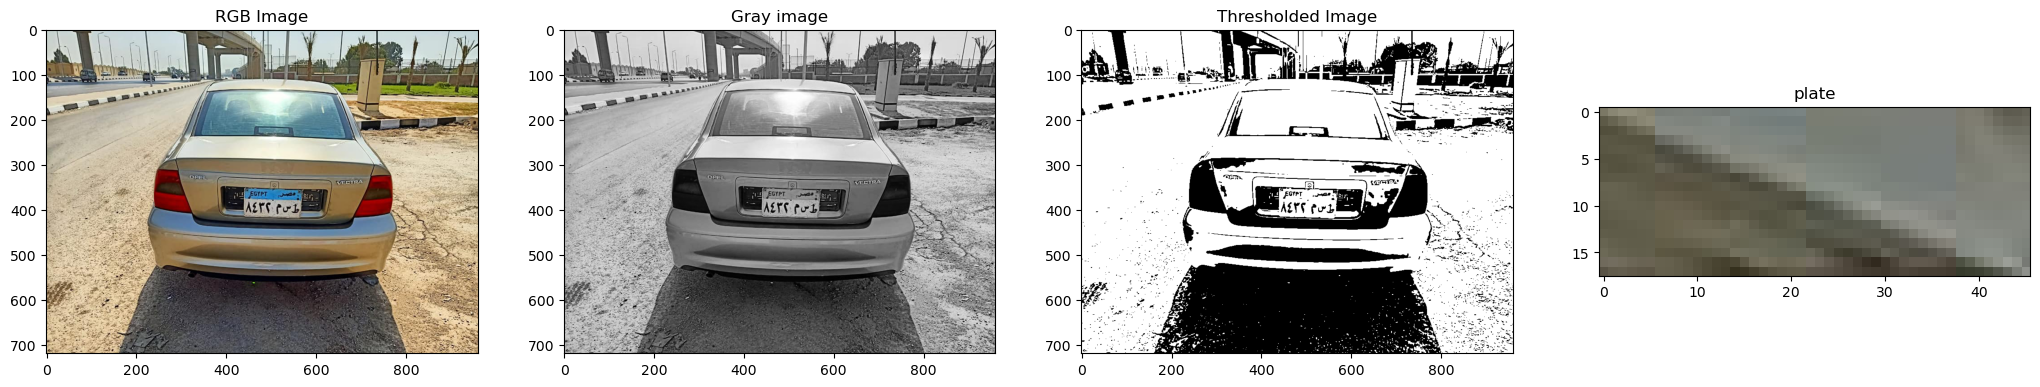

In [3]:
import cv2

img = io.imread('imgs/0006.jpg')

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray_img = (gray).astype(np.uint8)
filtered_img = cv2.bilateralFilter(gray_img, 5, 20, 100, borderType=cv2.BORDER_CONSTANT)



# Perform thresholding or other preprocessing steps as needed to isolate the plate
# For example, you can use adaptive thresholding
# thresh = cv2.adaptiveThreshold(filtered_img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
_, mask = cv2.threshold(filtered_img, 100, 255, cv2.THRESH_BINARY)

contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

plate = None
filtered_contours = []
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    aspect_ratio = float(w) / h
    area = cv2.contourArea(contour)
    if (aspect_ratio > 2.5) and (aspect_ratio < 3.5):
        filtered_contours.append(contour)

if filtered_contours:
    max_contour = max(filtered_contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(max_contour)
    plate = img[y:y + h, x:x + w]




show_images([img,gray,mask,plate],titles=['RGB Image','Gray image','Thresholded Image','plate'])


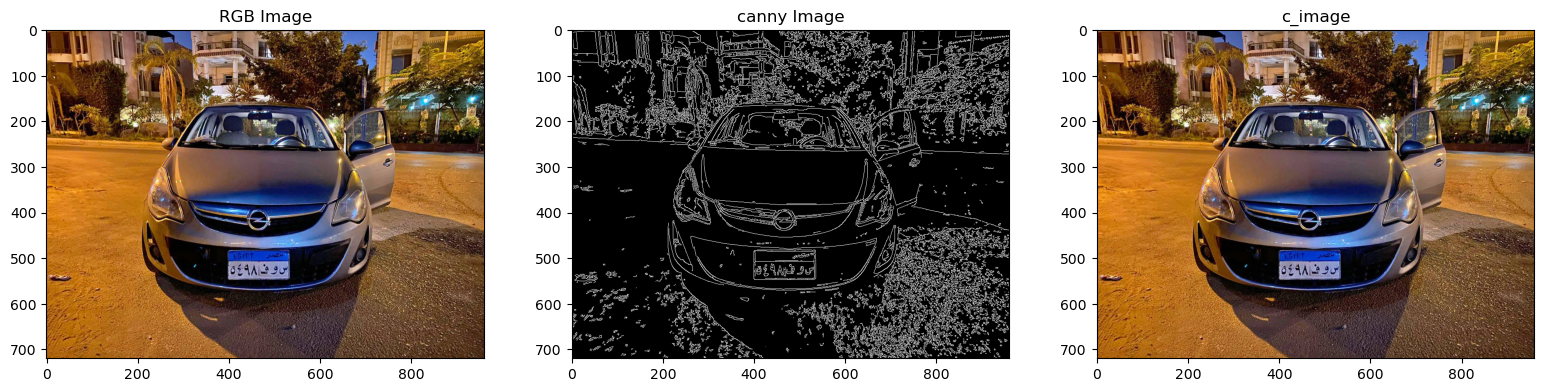

In [4]:
image = io.imread('imgs/0016.jpg')
c_image = image.copy()
img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

filtered_img = cv2.bilateralFilter(img_gray, 11, 20, 17)

img_canny = cv2.Canny(filtered_img, 70, 200)

# kernel = np.ones((3,3))
# img_dil = cv2.dilate(img_canny, kernel, iterations=2) 
points = cv2.findContours(img_canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
contours = imutils.grab_contours(points)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:80] 
# cv2.drawContours(c_image, contours, -1, (0, 255, 0), 2)

filtered_contours = []
for contour in contours:
   approx = cv2.approxPolyDP(contour, 60, True)
   if len(approx) == 4:
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = float(w) / h
        area = cv2.contourArea(contour)
        if (aspect_ratio > 2.5) and (aspect_ratio < 3.5) and (area < 500):
            filtered_contours.append(contour)

if filtered_contours:
    max_contour = max(filtered_contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(max_contour)
    cv2.rectangle(c_image, (x, y), (x + w, y + h), (0, 255, 0), 2)            


       

show_images([image,img_canny, c_image],titles=['RGB Image','canny Image','c_image'])   


33


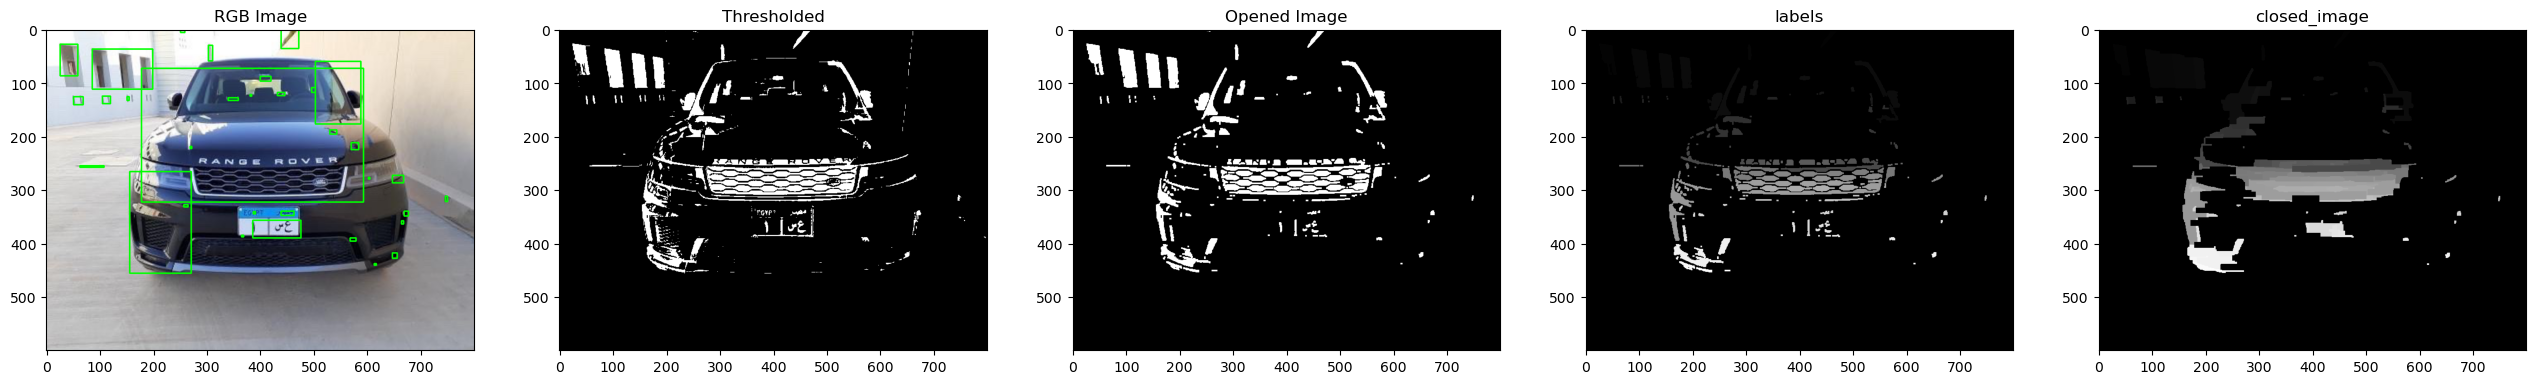

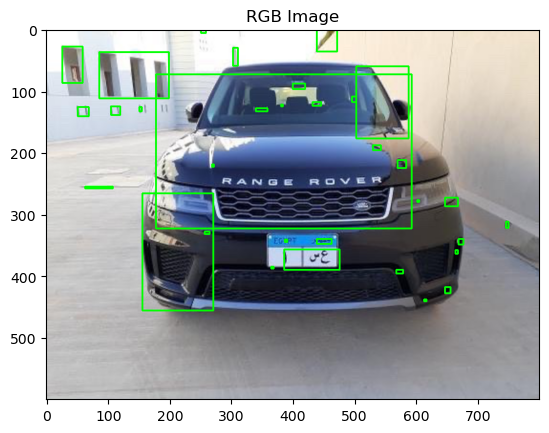

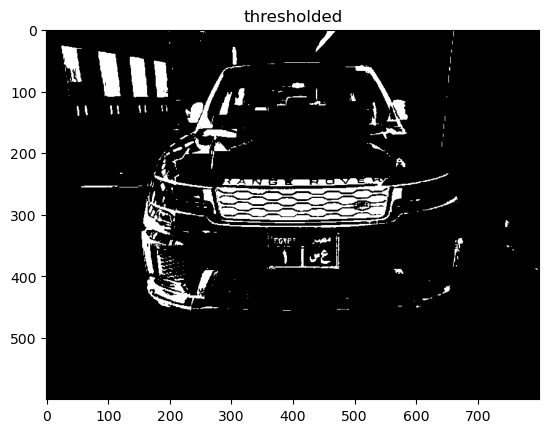

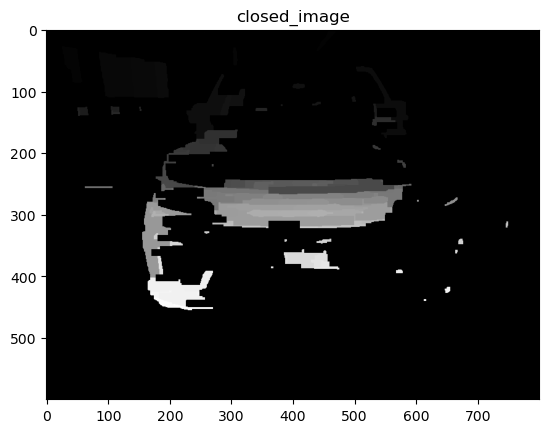

In [7]:
import cv2
from commonfunctions import *


# pipeline  (still needs some enhancements)
# 1- convert to gray
# 2- apply bottom hat
# 3- apply adaptive thresholding
# 4- apply opening
# 5- apply connected components
# 6- filter components by area
# 7- apply closing

image = io.imread('imgs/0047.jpg')
image = cv2.resize(image,(800,600))
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#kernel sizes
kernel_rect = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 10))
kernel_closing = cv2.getStructuringElement(cv2.MORPH_RECT, (30,10))
kernel_opening = np.ones((3, 3), np.uint8)

#apply morphological operations
bottom_hat = cv2.morphologyEx(image_gray, cv2.MORPH_BLACKHAT, kernel_rect) # search for blackhat morphological operation  
_, thresholded = cv2.threshold(bottom_hat, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) # search for adpative thresholding (otsu's)
opened_image = cv2.morphologyEx(thresholded, cv2.MORPH_OPEN, kernel_opening)

#contours 

num_labels, labels = cv2.connectedComponents(opened_image)
#print(labels)   

# erosed_image = cv2.erode(thresholded, kernel_square, iterations=1) 
# opened_image = cv2.morphologyEx(erosed_image, cv2.MORPH_OPEN, kernel_rect)

closed_image = cv2.morphologyEx(labels.astype(np.uint8), cv2.MORPH_CLOSE, kernel_closing)


edges = cv2.Canny(closed_image, 100, 200)
contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

contours = cv2.findContours(closed_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
contours = imutils.grab_contours(contours)
contours = sorted(contours, key=cv2.contourArea, reverse=True)

filtered_contours = []
plate = None
print(contours.__len__())
#filter contours by aspect ratio and area
for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    aspect_ratio = float(w) / h
    area = cv2.contourArea(contour)
    if area > 500 and area < 5000:
        filtered_contours.append(contour)


# if filtered_contours:
#     for contour in filtered_contours:
#         x, y, w, h = cv2.boundingRect(contour)
#         cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    # x, y, w, h = cv2.boundingRect(max_contour)
    # plate = image[y:y + h, x:x + w]
    # cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    # print(cv2.contourArea(max_contour))


    
    

show_images([image, thresholded , opened_image, labels,closed_image],titles=['RGB Image','Thresholded','Opened Image','labels','closed_image'])
show_images([image],titles=['RGB Image'])
show_images([thresholded],titles=['thresholded'])
show_images([closed_image],titles=['closed_image'])

